<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 1429, '日付': '2021-07-26T08:00:00.000Z'},
 {'小計': 2848, '日付': '2021-07-27T08:00:00.000Z'},
 {'小計': 3177, '日付': '2021-07-28T08:00:00.000Z'},
 {'小計': 3865, '日付': '2021-07-29T08:00:00.000Z'},
 {'小計': 3300, '日付': '2021-07-30T08:00:00.000Z'},
 {'小計': 4058, '日付': '2021-07-31T08:00:00.000Z'},
 {'小計': 3058, '日付': '2021-08-01T08:00:00.000Z'},
 {'小計': 2195, '日付': '2021-08-02T08:00:00.000Z'},
 {'小計': 3709, '日付': '2021-08-03T08:00:00.000Z'},
 {'小計': 4166, '日付': '2021-08-04T08:00:00.000Z'},
 {'小計': 5042, '日付': '2021-08-05T08:00:00.000Z'},
 {'小計': 4515, '日付': '2021-08-06T08:00:00.000Z'},
 {'小計': 4566, '日付': '2021-08-07T08:00:00.000Z'},
 {'小計': 4066, '日付': '2021-08-08T08:00:00.000Z'},
 {'小計': 2884, '日付': '2021-08-09T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-08-05 17:00:00+09:00,1528,0,5042,2021-08-05 17:00:00+09:00
2021-08-06 17:00:00+09:00,0,0,4515,2021-08-06 17:00:00+09:00
2021-08-07 17:00:00+09:00,0,0,4566,2021-08-07 17:00:00+09:00
2021-08-08 17:00:00+09:00,0,0,4066,2021-08-08 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-08-05 17:00:00+09:00,1528,0,5042,2021-08-05 17:00:00+09:00,1495.714286,10470.0,0.0,0.0,3646.857143,25528.0
2021-08-06 17:00:00+09:00,0,0,4515,2021-08-06 17:00:00+09:00,1314.857143,9204.0,0.0,0.0,3820.428571,26743.0
2021-08-07 17:00:00+09:00,0,0,4566,2021-08-07 17:00:00+09:00,1082.142857,7575.0,0.0,0.0,3893.000000,27251.0
2021-08-08 17:00:00+09:00,0,0,4066,2021-08-08 17:00:00+09:00,863.857143,6047.0,0.0,0.0,4037.000000,28259.0
2021-08-09 17:00:00+09:00,0,0,2884,2021-08-09 17:00:00+09:00,636.142857,4453.0,0.0,0.0,4135.428571,28948.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-07-26 17:00:00+09:00,1022,0,1429,2021-07-26 17:00:00+09:00,828.714286,5801.0,0.0,0.0,1553.857143,10877.0,'21w30,Mon
2021-07-27 17:00:00+09:00,1020,0,2848,2021-07-27 17:00:00+09:00,891.142857,6238.0,0.0,0.0,1762.571429,12338.0,'21w30,Tue
2021-07-28 17:00:00+09:00,1235,0,3177,2021-07-28 17:00:00+09:00,964.142857,6749.0,0.0,0.0,1954.714286,13683.0,'21w30,Wed
2021-07-29 17:00:00+09:00,1287,0,3865,2021-07-29 17:00:00+09:00,1018.428571,7129.0,0.0,0.0,2224.142857,15569.0,'21w30,Thu
2021-07-30 17:00:00+09:00,1266,0,3300,2021-07-30 17:00:00+09:00,1084.857143,7594.0,0.0,0.0,2501.428571,17510.0,'21w30,Fri
2021-07-31 17:00:00+09:00,1629,0,4058,2021-07-31 17:00:00+09:00,1185.857143,8301.0,0.0,0.0,2920.000000,20440.0,'21w30,Sat
2021-08-01 17:00:00+09:00,1528,0,3058,2021-08-01 17:00:00+09:00,1283.857143,8987.0,0.0,0.0,3105.000000,21735.0,'21w30,Sun
2021-08-02 17:00:00+09:00,1594,0,2195,2021-08-02 17:00:00+09:00,1365.571429,9559.0,0.0,0.0,3214.428571,22501.0,'21w31,Mon
2021-08-03 17:00:00+09:00,1384,0,3709,2021-08-03 17:00:00+09:00,1417.571429,9923.0,0.0,0.0,3337.428571,23362.0,'21w31,Tue
2021-08-04 17:00:00+09:00,1541,0,4166,2021-08-04 17:00:00+09:00,1461.285714,10229.0,0.0,0.0,3478.714286,24351.0,'21w31,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-07-25 17:00:00+09:00,1453.571429,10175
2021-08-01 17:00:00+09:00,3105.000000,21735
2021-08-08 17:00:00+09:00,4037.000000,28259
2021-08-09 17:00:00+09:00,2884.000000,2884
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-07-26 17:00:00+09:00,1022,0,1429,2021-07-26 17:00:00+09:00,828.714286,5801.0,0.0,0.0,1553.857143,10877.0,'21w30,Mon,NaN,NaN
2021-07-27 17:00:00+09:00,1020,0,2848,2021-07-27 17:00:00+09:00,891.142857,6238.0,0.0,0.0,1762.571429,12338.0,'21w30,Tue,NaN,NaN
2021-07-28 17:00:00+09:00,1235,0,3177,2021-07-28 17:00:00+09:00,964.142857,6749.0,0.0,0.0,1954.714286,13683.0,'21w30,Wed,NaN,NaN
2021-07-29 17:00:00+09:00,1287,0,3865,2021-07-29 17:00:00+09:00,1018.428571,7129.0,0.0,0.0,2224.142857,15569.0,'21w30,Thu,NaN,NaN
2021-07-30 17:00:00+09:00,1266,0,3300,2021-07-30 17:00:00+09:00,1084.857143,7594.0,0.0,0.0,2501.428571,17510.0,'21w30,Fri,NaN,NaN
2021-07-31 17:00:00+09:00,1629,0,4058,2021-07-31 17:00:00+09:00,1185.857143,8301.0,0.0,0.0,2920.000000,20440.0,'21w30,Sat,NaN,NaN
2021-08-01 17:00:00+09:00,1528,0,3058,2021-08-01 17:00:00+09:00,1283.857143,8987.0,0.0,0.0,3105.000000,21735.0,'21w30,Sun,3105.0,21735.0
2021-08-02 17:00:00+09:00,1594,0,2195,2021-08-02 17:00:00+09:00,1365.571429,9559.0,0.0,0.0,3214.428571,22501.0,'21w31,Mon,NaN,NaN
2021-08-03 17:00:00+09:00,1384,0,3709,2021-08-03 17:00:00+09:00,1417.571429,9923.0,0.0,0.0,3337.428571,23362.0,'21w31,Tue,NaN,NaN
2021-08-04 17:00:00+09:00,1541,0,4166,2021-08-04 17:00:00+09:00,1461.285714,10229.0,0.0,0.0,3478.714286,24351.0,'21w31,Wed,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

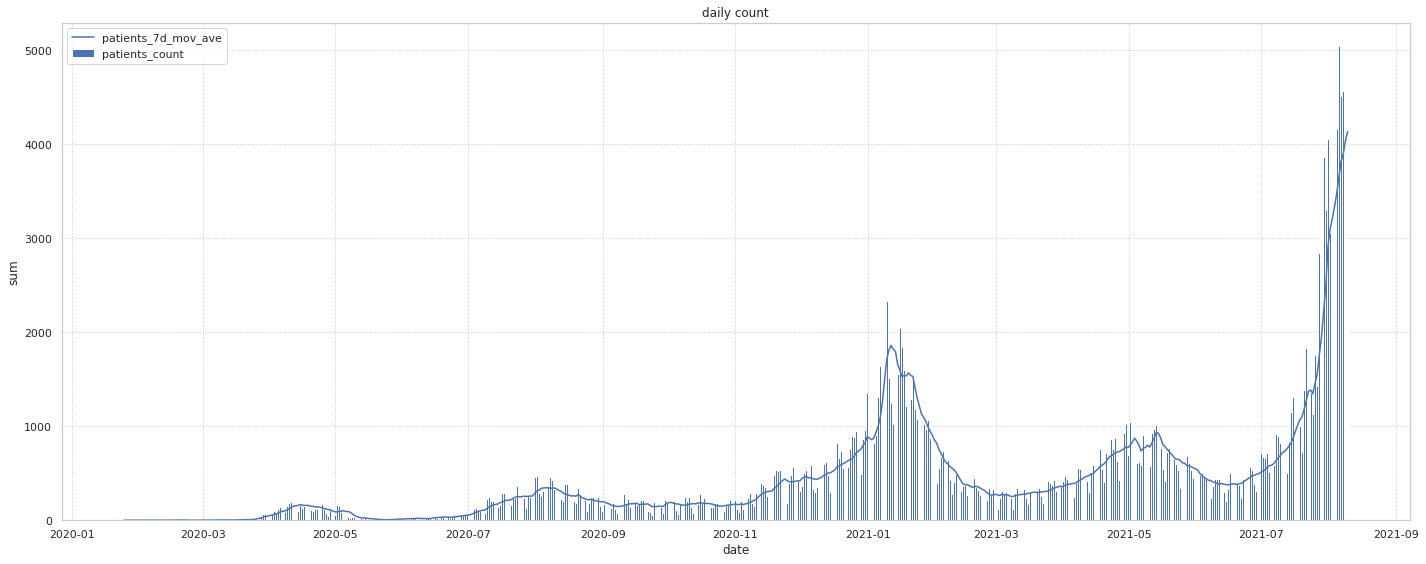

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
549,1.627286e+09,2021,7,26,0,1,0,0,0,0,0,549,0,475,1022,828.714286,5801.0,0,0.0,0.0,1429,1553.857143,10877.0
550,1.627373e+09,2021,7,27,0,0,0,0,0,1,0,550,0,476,1020,891.142857,6238.0,0,0.0,0.0,2848,1762.571429,12338.0
551,1.627459e+09,2021,7,28,0,0,0,0,0,0,1,551,0,477,1235,964.142857,6749.0,0,0.0,0.0,3177,1954.714286,13683.0
552,1.627546e+09,2021,7,29,0,0,0,0,1,0,0,552,0,478,1287,1018.428571,7129.0,0,0.0,0.0,3865,2224.142857,15569.0
553,1.627632e+09,2021,7,30,1,0,0,0,0,0,0,553,0,479,1266,1084.857143,7594.0,0,0.0,0.0,3300,2501.428571,17510.0
554,1.627718e+09,2021,7,31,0,0,1,0,0,0,0,554,0,480,1629,1185.857143,8301.0,0,0.0,0.0,4058,2920.000000,20440.0
555,1.627805e+09,2021,8,1,0,0,0,1,0,0,0,555,0,481,1528,1283.857143,8987.0,0,0.0,0.0,3058,3105.000000,21735.0
556,1.627891e+09,2021,8,2,0,1,0,0,0,0,0,556,0,482,1594,1365.571429,9559.0,0,0.0,0.0,2195,3214.428571,22501.0
557,1.627978e+09,2021,8,3,0,0,0,0,0,1,0,557,0,483,1384,1417.571429,9923.0,0,0.0,0.0,3709,3337.428571,23362.0
558,1.628064e+09,2021,8,4,0,0,0,0,0,0,1,558,0,484,1541,1461.285714,10229.0,0,0.0,0.0,4166,3478.714286,24351.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            564 non-null    float64
 1   year                 564 non-null    int64  
 2   month                564 non-null    int64  
 3   day                  564 non-null    int64  
 4   Fri                  564 non-null    uint8  
 5   Mon                  564 non-null    uint8  
 6   Sat                  564 non-null    uint8  
 7   Sun                  564 non-null    uint8  
 8   Thu                  564 non-null    uint8  
 9   Tue                  564 non-null    uint8  
 10  Wed                  564 non-null    uint8  
 11  passed               564 non-null    int64  
 12  emergency            564 non-null    int64  
 13  em_passed            564 non-null    int64  
 14  contacts_count       564 non-null    int64  
 15  contacts_7d_mov_ave  564 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.640000e+02,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.00000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,1.604174e+09,2020.391844,5.824468,15.702128,0.143617,0.143617,0.143617,0.143617,0.141844,0.141844,0.141844,281.50000,0.086879,212.420213,659.735816,658.572400,4610.000000,653.402482,653.402482,4573.817376,447.108156,425.913450,2981.365248
std,1.407949e+07,0.488595,3.149226,8.888290,0.351012,0.351012,0.351012,0.351012,0.349200,0.349200,0.349200,162.95705,0.281908,155.693381,433.472770,415.384402,2907.701547,852.113612,771.082100,5397.574700,658.488935,576.377430,4034.663378
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.592014e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,140.75000,0.000000,66.750000,374.750000,380.000000,2660.000000,0.000000,0.000000,0.000000,87.000000,99.142857,694.000000
50%,1.604174e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,281.50000,0.000000,207.500000,520.500000,539.642857,3777.500000,0.000000,0.000000,0.000000,258.000000,267.571429,1873.000000
75%,1.616335e+09,2021.000000,8.000000,23.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,422.25000,0.000000,348.250000,778.250000,760.321429,5322.250000,1295.500000,1270.250000,8891.750000,539.750000,534.607143,3742.250000
max,1.628496e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,563.00000,1.000000,489.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,5042.000000,4135.428571,28948.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.845523,0.127713,-0.009940,-0.003773,0.003773,-0.001258,0.001258,0.002497,-0.002497,3.364580e-19,1.000000e+00,-0.347650,0.996693,-0.252296,-0.238869,-0.238864,-0.576533,-0.621492,-0.621492,0.580722,0.613522,0.613531
year,8.455230e-01,1.000000,-0.419269,-0.043015,0.002699,0.002699,0.002699,0.002699,-0.003618,-0.003618,-3.617805e-03,8.455230e-01,-0.247596,0.859581,-0.257890,-0.240937,-0.240934,-0.616052,-0.680792,-0.680792,0.513679,0.559230,0.559233
month,1.277130e-01,-0.419269,1.000000,-0.029411,-0.012504,0.001957,-0.007684,-0.002863,0.011375,0.003299,6.529345e-03,1.277130e-01,-0.128842,0.095805,0.052376,0.045547,0.045551,0.166300,0.211564,0.211564,0.033579,0.006036,0.006047
day,-9.940468e-03,-0.043015,-0.029411,1.000000,0.011459,-0.005620,0.005196,-0.000497,-0.004103,-0.008681,2.191665e-03,-9.940468e-03,-0.000287,-0.009156,-0.001626,-0.023272,-0.023275,0.011320,-0.001508,-0.001508,-0.027429,-0.046312,-0.046319
Fri,-3.772875e-03,0.002699,-0.012504,0.011459,1.000000,-0.167702,-0.167702,-0.167702,-0.166491,-0.166491,-1.664912e-01,-3.772875e-03,-0.000668,-0.002959,-0.024428,-0.002296,-0.002295,0.030740,-0.001838,-0.001838,0.028781,-0.001046,-0.001050
Mon,3.772875e-03,0.002699,0.001957,-0.005620,-0.167702,1.000000,-0.167702,-0.167702,-0.166491,-0.166491,-1.664912e-01,3.772875e-03,-0.000668,0.003866,0.033800,-0.002296,-0.002295,0.126455,-0.001838,-0.001838,-0.094895,0.013392,0.013393
Sat,-1.257625e-03,0.002699,-0.007684,0.005196,-0.167702,-0.167702,1.000000,-0.167702,-0.166491,-0.166491,-1.664912e-01,-1.257625e-03,-0.000668,-0.000684,0.039473,-0.002296,-0.002295,-0.149551,-0.001838,-0.001838,0.042444,0.004679,0.004676
Sun,1.257625e-03,0.002699,-0.002863,-0.000497,-0.167702,-0.167702,-0.167702,1.000000,-0.166491,-0.166491,-1.664912e-01,1.257625e-03,-0.000668,0.001591,-0.030020,-0.002296,-0.002295,-0.137918,-0.001838,-0.001838,-0.023006,0.009776,0.009776
Thu,2.497092e-03,-0.003618,0.011375,-0.004103,-0.166491,-0.166491,-0.166491,-0.166491,1.000000,-0.165289,-1.652893e-01,2.497092e-03,0.000896,0.001679,0.005575,0.005756,0.005757,0.039802,0.002463,0.002463,0.061389,-0.002992,-0.002989
Tue,-2.497092e-03,-0.003618,0.003299,-0.008681,-0.166491,-0.166491,-0.166491,-0.166491,-0.165289,1.000000,-1.652893e-01,-2.497092e-03,0.000896,-0.002895,-0.020944,0.000387,0.000388,0.053609,0.002463,0.002463,-0.028995,-0.014600,-0.014598


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,1.628150e+09,0,0,0,0,1,0,0,559,0,485,1528,0,5042,3646.857143,25528.0
560,1.628237e+09,1,0,0,0,0,0,0,560,0,486,0,0,4515,3820.428571,26743.0
561,1.628323e+09,0,0,1,0,0,0,0,561,0,487,0,0,4566,3893.000000,27251.0
562,1.628410e+09,0,0,0,1,0,0,0,562,0,488,0,0,4066,4037.000000,28259.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
559,1.628150e+09,559,0,5042,3646.857143,25528.0
560,1.628237e+09,560,0,4515,3820.428571,26743.0
561,1.628323e+09,561,0,4566,3893.000000,27251.0
562,1.628410e+09,562,0,4066,4037.000000,28259.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

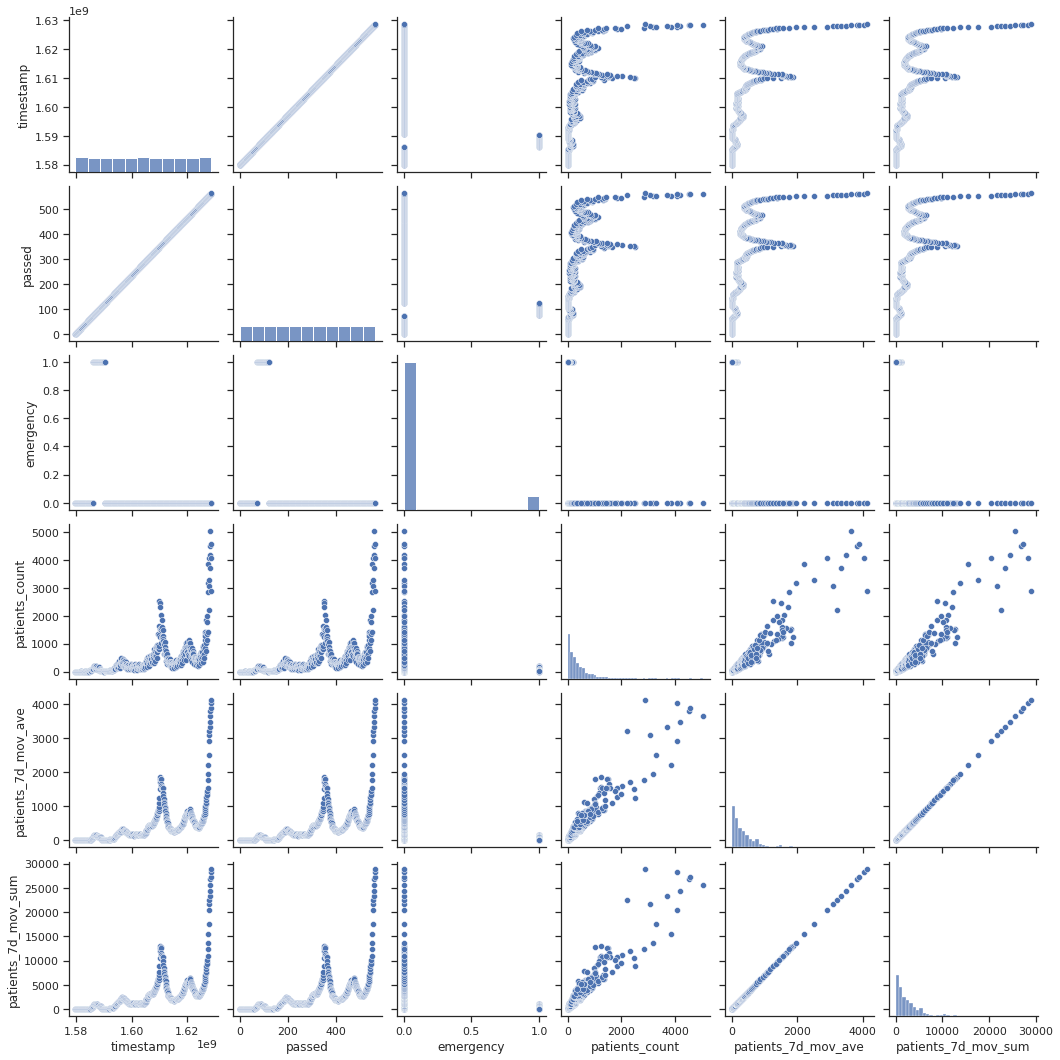

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.11
